# Build a Long/Short Pairs Portfolio to maximum the PnL

1.   Base on **stocksInfo** and **researchData** only to **identify  Pairs** and calculate **trading parameters**. No additional data is allowed
2.   Based on **testData** to **backtest** the Pairs portfolio with **signals** and **dollarValue**
3.   Calculate the **PnL** of the backtested Pairs portfolio



# Rules
 

*   **No look-ahead bias**: The testData cannot be used for Pairs identification nor the trading parameters calculations. During backtest, can only refer to **look-back indicators**
*   **No overfitting**: The selected Pairs cannot be hand-picked and must be based on rules. Similarly for the trading parameters and dollarValue, apart from the obvious numbers (e.g. 0.05, 0.1, 0.5, 1, 100, 1000 etc.), they must be based on rules also.

In [2]:
!pip install --upgrade openpyxl

     |████████████████████████████████| 242 kB 5.0 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas_datareader.data as web

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6

%load_ext google.colab.data_table 
%matplotlib inline

# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

# Load the stockInfo, researchData and testData
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())



  plt.show()



# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)

# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf



### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, dollarValue=10000):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}
  tradingParams['dollarValue'] = dollarValue

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams



--2022-02-04 15:54:21--  https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py [following]
--2022-02-04 15:54:21--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2949 (2.9K) [text/plain]
Saving to: ‘pairslib.py’

pairslib.py         100%[===================>]   2.88K  --.-KB/s    in 0s      

2022-02-04 15:54:21 (35.7 MB/s) - ‘pairslib.py’ saved [2949/2949]



In [4]:
# Implement your logic to construct "pairsPortfolioBackTest"
# pairsPortfolioBackTest needs to be same format as in
# https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/HKStocksCorrelation.ipynb
# It is a list of backtested Pairs
# Each backtested Pairs is a dataframe with at least 5 columns (Date, stockA, stockB, signal, dollarValue)

# signal is -1, 0, 1
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
# dollarValue if not specified, it will default to 10000. 
# Can customize each pair with different dollarValue and the allowable range is 5000 to 20000. 

def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)


  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']



  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df



#Use researchData to calculate the optimal PnL, so use the resecahData instead of testData
def backTest2(researchData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = researchData[cols].copy()
  backTest_df.dropna(inplace = True)


  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']



  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df

# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest    

#Use researchData to calculate the optimal PnL, so use the resecahData instead of testData
def researchAndBackTestPortfolio2(pairsDf, researchData, printOutput=True):
  pairsPortfolioBackTest2 = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest2.append(backTest(researchData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest2 

**1. Source the stocks data**

In [5]:
# Get the pre-downloaded (2020-Jul) all HK stocks information from yahoo and merged with stock sectors
# Pandas support reading Excel directly
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
stocksInfo


,code,shortName,industry,sector,language,region,quoteType,quoteSourceName,triggerable,currency,marketState,exchange,longName,messageBoardId,exchangeTimezoneName,exchangeTimezoneShortName,gmtOffSetMilliseconds,market,esgPopulated,firstTradeDateMilliseconds,priceHint,regularMarketChange,regularMarketChangePercent,regularMarketTime,regularMarketPrice,regularMarketDayHigh,regularMarketDayRange,regularMarketDayLow,regularMarketVolume,regularMarketPreviousClose,bid,ask,bidSize,askSize,fullExchangeName,financialCurrency,regularMarketOpen,averageDailyVolume3Month,averageDailyVolume10Day,fiftyTwoWeekLowChange,fiftyTwoWeekLowChangePercent,fiftyTwoWeekRange,fiftyTwoWeekHighChange,fiftyTwoWeekHighChangePercent,fiftyTwoWeekLow,fiftyTwoWeekHigh,trailingAnnualDividendRate,trailingAnnualDividendYield,sharesOutstanding,bookValue,fiftyDayAverage,fiftyDayAverageChange,fiftyDayAverageChangePercent,twoHundredDayAverage,twoHundredDayAverageChange,twoHundredDayAverageChangePercent,marketCap,priceToBook,sourceInterval,exchangeDataDelayedBy,tradeable,price,earningsTimestamp,earningsTimestampStart,earningsTimestampEnd,trailingPE,epsTrailingTwelveMonths,epsForward,forwardPE,dividendDate
0,4333.HK,CISCO-T,Information Technology,Telecommunications Equipment,en-US,US,EQUITY,Delayed Quote,False,HKD,REGULAR,HKG,"Cisco Systems, Inc.",finmb_19691,Asia/Hong_Kong,HKT,28800000,hk_market,False,9.597366e+11,3,0.000000,0.000000,1594885107,150.00,150.00,150.0 - 150.0,150.00,50.0,150.00,150.00,10.00,0.0,0.0,HKSE,USD,150.00,0.0,0.0,0.000000,0.000000,150.0 - 400.0,-250.000000,-0.625000,150.00,400.00,1.410,0.009400,4.222300e+09,8.462,321.428560,-171.428560,-0.533333,380.769230,-230.769230,-0.606061,1.528620e+12,17.726307,15,0,False,150.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4335.HK,INTEL-T,Information Technology,Semi-conductor,en-US,US,EQUITY,Delayed Quote,False,HKD,REGULAR,HKG,Intel Corporation,finmb_21127,Asia/Hong_Kong,HKT,28800000,hk_market,False,9.597366e+11,3,0.000000,0.000000,1595224321,300.00,300.00,300.0 - 300.0,300.00,60.0,300.00,301.00,NaN,NaN,NaN,HKSE,USD,300.00,0.0,0.0,50.000000,0.200000,250.0 - 400.0,-100.000000,-0.250000,250.00,400.00,1.290,0.004300,4.253000e+09,19.283,270.285700,29.714294,0.109937,289.930080,10.069916,0.034732,1.584567e+12,15.557744,15,0,False,300.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4338.HK,MICROSOFT-T,Information Technology,Technology and Software,en-US,US,EQUITY,Delayed Quote,False,HKD,REGULAR,HKG,Microsoft Corporation,finmb_21835,Asia/Hong_Kong,HKT,28800000,hk_market,False,9.597366e+11,3,0.000000,0.000000,1589523065,500.00,500.00,500.0 - 500.0,500.00,20.0,500.00,800.00,NaN,NaN,NaN,HKSE,USD,500.00,0.0,0.0,0.000000,0.000000,500.0 - 600.0,-100.000000,-0.166667,500.00,600.00,2.040,0.004080,7.571000e+09,15.626,500.000000,0.000000,0.000000,500.000000,0.000000,0.000000,1.197435e+13,31.997952,15,0,False,500.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9988.HK,BABA-SW,Information Technology,E-commerce and Internet,en-US,US,EQUITY,Delayed Quote,False,HKD,REGULAR,HKG,Alibaba Group Holding Limited,finmb_42083601,Asia/Hong_Kong,HKT,28800000,hk_market,False,1.574732e+12,3,3.399994,1.388886,1596160874,248.20,249.00,246.6 - 249.0,246.60,3471005.0,244.80,248.20,248.40,NaN,NaN,HKSE,CNY,249.00,26842674.0,25690873.0,80.599990,0.480907,167.6 - 263.8,-15.599991,-0.059136,167.60,263.80,NaN,NaN,2.146180e+10,NaN,230.531430,17.668564,0.076643,208.486010,39.713990,0.190488,5.370378e+12,NaN,15,0,False,248.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0700.HK,TENCENT,Information Technology,Online and Mobile Games,en-US,US,EQUITY,Delayed Quote,False,HKD,REGULAR,HKG,Tencent Holdings Limited,finmb_11042136,Asia/Hong_Kong,HKT,28800000,hk_market,False,1.087349e+12,3,13.000000,2.429907,1596160874,548.00,550.00,539.5 - 550.0,539.50,3691046.0,535.00,547.00,547.50,0.0,0.0,HKSE,CNY,540.00,21400492.0,20457768.0,235.799990,0.755285,312.2 - 564.0,-16.000000,-0.028369,312.20,564.00,0.111,0.000207,9.555170e+09,5.056,508.074280,39.925720,0.078582,426.177600,121.822390,0.285849,5.236233e+12,108.386

In [6]:
# list the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)

Count: 23
['Information Technology' 'Financial' 'Telecommunications' 'Energy'
 'Food and Beverage' 'Real Estate Construction' 'Meida and Communications'
 'Medicine' 'Betting' 'Transportation, logistics and infrastructure'
 'Consumer Goods Manufacturing' 'Conglomerate' 'Retail' 'Electricity'
 'Automobile production and distribution' 'Industry'
 'Environmental protection' 'Consumer Service' 'Industrial Products'
 'Raw Materials' 'Index leveraged products' 'Fund' 'ETF']


In [7]:
# list the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['Telecommunications Equipment' 'Semi-conductor' 'Technology and Software'
 'E-commerce and Internet' 'Online and Mobile Games'
 'State-owned China banks' 'China Telecom' 'International Insurance'
 'Bank' 'China Insurance' 'Other financial services' 'Oil and gas'
 'Alcoholic Beverages' 'Real Estate Development'
 'Media Entertainment Culture Publishing' 'Pharmaceutical'
 'China Properties' 'Macau Gaming' 'Public Transport' 'Toys'
 'Conglomerate' 'Biotechnology' 'Sporting Goods'
 'Gas and Public Utilities' 'Catering' 'Electric utility' 'Supermarket'
 'small and medium China banks' 'Automobile' 'Mobile phone related'
 'Machinery' 'Dairy related' 'Textile and Clothing' 'Healthcare'
 'Property Management and Agent' 'Auto sales' 'Infrastructure'
 'Agricultural and Fishery products'
 'Food and beverage Production and Wholesale' 'Local Telecom'
 'Real Estate Investment' 'Water utilities' 'Jewelry Watches' 'Snack Food'
 'Cement' 'Clothing Accessories' 'Photovoltaic Solar' 'Packaged f

**2. Stock Selection:**


In [8]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

,code,quoteType,shortName,industry,sector,marketCap,regularMarketPreviousClose,averageDailyVolume10Day
2,4338.HK,EQUITY,MICROSOFT-T,Information Technology,Technology and Software,1.197435e+13,500.00,0.0
3,9988.HK,EQUITY,BABA-SW,Information Technology,E-commerce and Internet,5.370378e+12,244.80,25690873.0
4,0700.HK,EQUITY,TENCENT,Information Technology,Online and Mobile Games,5.236233e+12,535.00,20457768.0
14,1398.HK,EQUITY,ICBC,Financial,State-owned China banks,2.752837e+12,4.65,161543498.0
11,2318.HK,EQUITY,PING AN,Financial,China Insurance,1.820020e+12,82.65,31290439.0
...,...,...,...,...,...,...,...,...
2729,83170.HK,EQUITY,ISHARESKS200-R,ETF,Equities-Asia (except Japan),NaN,88.02,NaN
2730,83186.HK,EQUITY,CICCKRANECNET-R,ETF,Equities-China,NaN,79.14,NaN
2731,83188.HK,EQUITY,CAM CSI300-R,ETF,Equities-China,NaN,47.30,661361.0
2732,83197.HK,EQUITY,CAM MSCI AINC-R,ETF,Equities-China,NaN,11.32,10550.0


In [9]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

,code,shortName,industry,sector,turnover
1,0700.HK,TENCENT,Information Technology,Online and Mobile Games,1.094491e+10
0,9988.HK,BABA-SW,Information Technology,E-commerce and Internet,6.289126e+09
27,0981.HK,SMIC,Information Technology,Semi-conductor,5.881712e+09
3,3690.HK,MEITUAN-W,Information Technology,E-commerce and Internet,4.727324e+09
8,0388.HK,HKEX,Financial,Other financial services,2.732908e+09
...,...,...,...,...,...
140,0136.HK,HENGTEN NET,Energy,Photovoltaic Solar,1.084515e+08
91,0880.HK,SJM HOLDINGS,Betting,Macau Gaming,1.077015e+08
158,3606.HK,FUYAO GLASS,Automobile production and distribution,Cars parts and maintenance,1.056159e+08
152,3933.HK,UNITED LAB,Medicine,Pharmaceutical,1.038379e+08


In [10]:
# Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [11]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

,industry,count,shortName,marketCap,turnover
8,Financial,28,"CCB, AIA, HSBC HOLDINGS, PING AN, HKEX, ICBC, ...",1.662362e+13,1.751066e+10
18,Real Estate Construction,23,"EVERGRANDE, SHK PPT, CHINA OVERSEAS, CHINA RES...",3.465236e+12,6.341136e+09
15,Medicine,22,"ALI HEALTH, WUXI BIO, HANSOH PHARMA, SINO BIOP...",2.261904e+12,1.014198e+10
14,Information Technology,19,"BABA-SW, TENCENT, MEITUAN-W, SMIC, SUNNY OPTIC...",1.274662e+13,3.449564e+10
6,Energy,13,"CNOOC, HK & CHINA GAS, CHINA GAS HOLD, ENN ENE...",2.944557e+12,3.686595e+09
0,Automobile production and distribution,11,"GEELY AUTO, ZHONGSHENG HLDG, BYD COMPANY, BRIL...",1.072087e+12,4.129304e+09
9,Food and Beverage,7,"BUD APAC, HAIDILAO, MENGNIU DAIRY, CHINA FEIHE...",1.090421e+12,2.078364e+09
20,Telecommunications,6,"CHINA MOBILE, XIAOMI-W, CHINA UNICOM, CHINA TO...",2.215377e+12,4.606182e+09
17,Raw Materials,6,"ND PAPER, ZIJIN MINING, SD GOLD, CMOC, ZHAOJIN...",5.376691e+11,1.482049e+09
3,Consumer Goods Manufacturing,5,"SHENZHOU INTL, WH GROUP, MAN WAH HLDGS, GOME R...",3.151504e+11,1.445468e+09


In [12]:
# download the daily stock price info (Open, High, Low, Close, Volume) 
startDate = '2020-1-1'
allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")

stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)

columnNames = list(researchData.columns)
researchData

,BABA-SW,TENCENT,CCB,MEITUAN-W,CHINA MOBILE,AIA,HSBC HOLDINGS,PING AN,HKEX,ICBC,CNOOC,XIAOMI-W,BUD APAC,EVERGRANDE,EVERG HEALTH,ALI HEALTH,SHK PPT,CHINA OVERSEAS,HANG SENG BANK,SANDS CHINA LTD,MTR CORPORATION,CHINA RES LAND,BOC HONG KONG,LONGFOR GROUP,GALAXY ENT,BANK OF CHINA,COUNTRY GARDEN,SMIC,WUXI BIO,HANSOH PHARMA,ANTA SPORTS,HK & CHINA GAS,CKH HOLDINGS,SINO BIOPHARM,HAIDILAO,CLP HOLDINGS,CHINA RES BEER,CM BANK,SUNAC,GEELY AUTO,...,PICC GROUP,AIR CHINA,GAC GROUP,ZA ONLINE,TIANNENG POWER,FOSUN PHARMA,XD INC,HENGTEN NET,CGS,ZTE,HOPE EDU,VIVA BIOTECH,SD GOLD,YEAHKA,YONGDA AUTO,DONGFENG GROUP,CHINASOFT INT'L,CSC,CRRC TIMES ELEC,UNITED LAB,CC NEW LIFE,POLY PPT DEV,COFCO MEAT,CMOC,PHARMARON,FUYAO GLASS,ZOOMLION,MEILAN AIRPORT,ZHAOJIN MINING,GANFENGLITHIUM,HKTV,COMEC,EB SECURITIES,CHINA DONGXIANG,FLAT GLASS,HEC PHARM,BROAD HOMES,FI2 CSOP HSI,FL2 CSOP HSI,LINK REIT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,210.000000,380.297546,6.011992,103.500000,57.697662,82.010986,58.445934,87.541428,249.938675,5.350135,11.294235,11.220000,26.049772,19.712416,7.840000,9.130000,111.786102,27.469000,149.835770,41.636250,43.325699,36.348351,24.300215,34.834248,60.077793,2.910120,11.370209,12.700000,33.566666,25.131157,69.048111,13.093070,67.696716,7.244797,32.188019,75.626793,42.009102,38.807209,42.783207,15.122741,...,2.936266,8.102020,9.242115,29.250000,5.723353,23.074917,18.520000,1.16,4.316857,23.942434,1.401733,4.487556,12.803354,NaN,6.811226,6.554184,4.517895,6.403025,28.950100,5.423173,NaN,45.965645,1.888197,3.402090,42.256992,23.429314,6.415996,5.450000,8.444615,18.839043,3.434652,5.812789,6.312775,0.776677,5.291602,21.673248,8.035072,6.120,10.400,77.429619
2020-01-03,212.000000,380.894257,5.941263,104.199997,56.858910,82.495110,57.966084,88.242493,255.889633,5.305920,11.520469,10.900000,26.344673,19.357233,7.830000,9.120000,111.786102,26.797932,149.281525,41.344067,43.136917,35.471935,24.390049,34.223949,58.296242,2.901485,11.105374,12.640000,33.866665,25.230686,68.407860,13.075911,67.333244,7.126247,32.934258,75.351608,41.416035,38.854248,41.864548,15.277844,...,2.900996,7.945081,9.251507,28.450001,5.714062,23.026440,18.120001,1.15,4.298565,24.825558,1.451090,4.507456,13.495810,NaN,6.745007,6.571569,4.586946,6.356894,28.217804,5.403873,NaN,46.212509,1.830226,3.343768,43.003578,23.618643,6.378801,5.600000,8.869314,19.352476,3.394945,5.803052,6.341688,0.776677,5.281712,20.329361,7.978421,6.170,10.320,76.912170
2020-01-06,211.000000,375.325012,5.879375,109.500000,56.726471,81.623695,57.582199,87.728371,257.809265,5.244017,11.938129,10.980000,25.853168,19.312838,7.730000,8.810000,110.748428,26.395294,148.080612,41.879734,42.948128,34.780022,24.300215,33.848370,57.553932,2.841037,10.875851,13.040000,32.516666,25.330215,68.506363,13.041591,66.833481,6.915489,32.188019,74.892998,41.020653,38.477936,40.420944,14.967634,...,2.900996,7.533113,9.204546,28.650000,5.630442,22.735580,18.400000,1.16,4.252836,25.414305,1.460961,4.358202,14.004552,NaN,6.669326,6.397719,4.517895,6.347668,27.290230,5.345975,NaN,46.311256,1.838508,3.217405,42.804493,24.186625,6.276517,5.680000,9.303892,21.080378,3.385018,5.841999,6.360963,0.758823,5.271821,20.280495,7.761257,6.270,10.160,76.347679
2020-01-07,212.600006,383.479980,5.844010,110.400002,56.329166,82.591942,57.486233,87.494682,258.961060,5.226330,11.868520,11.000000,26.197224,18.868864,7.750000,9.860000,110.371086,26.395294,148.727264,42.171921,42.664955,35.010658,24.255299,34.787300,58.593166,2.832402,10.981784,12.600000,33.666664,25.479509,72.150841,13.058750,66.379135,7.047213,33.332256,75.305748,41.317188,38.430897,40.508434,15.200293,...,2.892178,7.582157,9.176368,29.700001,5.751227,22.784056,19.000000,1.17,4.261981,25.218058,1.480704,4.398003,13.933894,NaN,6.669326,6.345563,4.557353,6.393799,27.778427,5.365274,NaN,46.015018,1.904760,3.295167,43.103123,23.855303,6.295115,5.760000,9.135987,20.586691,3.533919,5.793315,6.360963,0.758823,5.637782,20.329361,

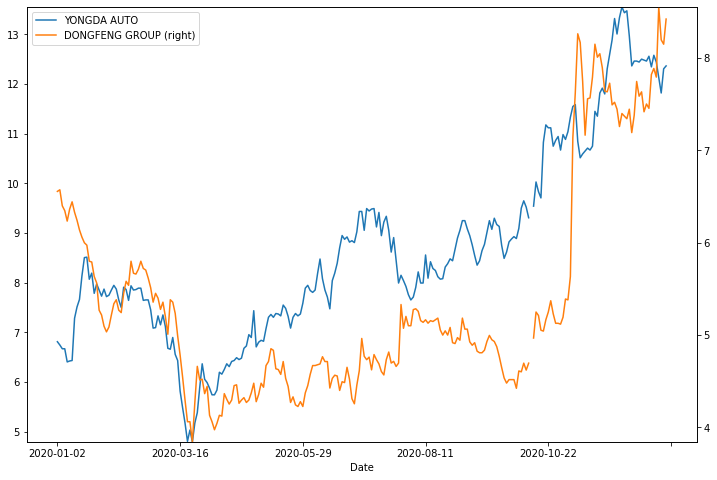

In [13]:
# Pick 2 stocks price chart to to show the price correlation in research period
stockA = 'YONGDA AUTO'
stockB = 'DONGFENG GROUP'
plotPair(researchData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

**3. Pair Identifications**

In [14]:
# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='RdBu', axis=None)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# filter the pairs with correlation values above the THRESHOLD
# This THRESHOLD value is calculated by the following for loop program in researchData


THRESHOLD = 0.9
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

pairsDf.round(4)

,stockA,stockB,corr,sector_A,sector_B,sameSector
0,FLAT GLASS,XINYI SOLAR,0.9868,Glass strands,Photovoltaic Solar,False
1,MEIDONG AUTO,MEITUAN-W,0.9813,Auto sales,E-commerce and Internet,False
2,MAN WAH HLDGS,ZIJIN MINING,0.9769,Housewares,Precious metals,False
3,TENCENT,ZHONGSHENG HLDG,0.9737,Online and Mobile Games,Auto sales,False
4,XINYI GLASS,XINYI SOLAR,0.9733,Glass strands,Photovoltaic Solar,False
...,...,...,...,...,...,...
464,FL2 CSOP HSI,BOC HONG KONG,0.9005,Index Leveraged Product,Bank,False
465,BYD ELECTRONIC,HENGTEN NET,0.9005,Mobile phone related,Photovoltaic Solar,False
466,CSC,COMEC,0.9002,Other financial services,Shipbuilding related,False
467,MEIDONG AUTO,FLAT GLASS,0.9001,Auto sales,Glass strands,False


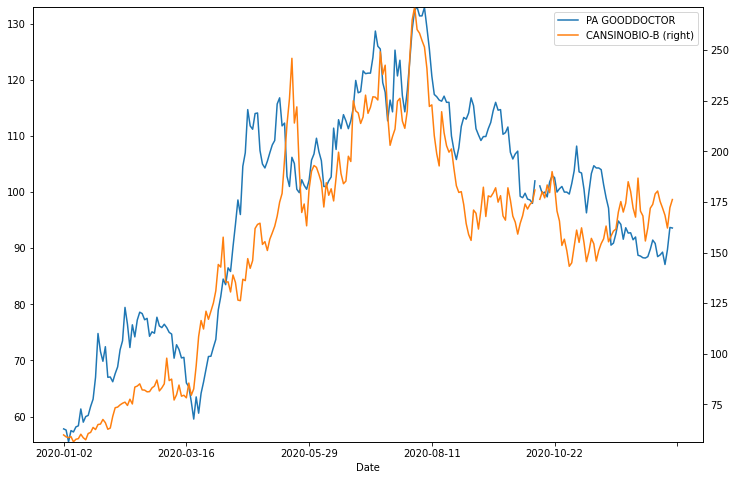

In [16]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 430

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)

**4. Trading Parameters (Entry/Exit Point)**

In [17]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

,PA GOODDOCTOR,CANSINOBIO-B,PA GOODDOCTOR / CANSINOBIO-B
Date,,,
2020-01-02,57.799999,59.849998,0.965748
2020-01-03,57.599998,58.900002,0.977929
2020-01-06,55.500000,58.500000,0.948718
2020-01-07,57.500000,59.000000,0.974576
2020-01-08,57.250000,56.450001,1.014172
...,...,...,...
2020-12-24,89.300003,172.000000,0.519186
2020-12-28,87.099998,168.399994,0.517221
2020-12-29,89.750000,162.100006,0.553671


In [18]:
# Calculate the trading parameters from research period
#This parameter value is calculated by the following for loop program in researchData

threshold=PX_RATIO_THRESHOLD=0.2
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

tradingParams

{'avgPxRatio': 0.6711661448930085,
 'dollarValue': 0.2,
 'longA_shortB_ratio': 0.5369329159144068,
 'shortA_longB_ratio': 0.8053993738716102}

Average BUY/SELL price ratio of PA GOODDOCTOR / CANSINOBIO-B in research period: 0.6711661448930085
Entry Point (Divergence) Signal -1 (Long A Short B): Long PA GOODDOCTOR and Short CANSINOBIO-B when the BUY/SELL price ratio < 0.5369329159144068
Entry Point (Divergence) Signal +1 (Short A Long B): Short PA GOODDOCTOR and Long CANSINOBIO-B when the BUY/SELL price ratio > 0.8053993738716102
Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio:  0.6711661448930085


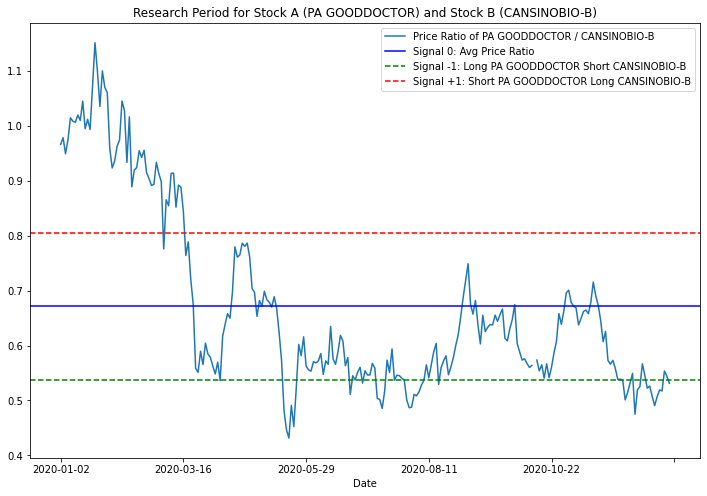

In [19]:
avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']

print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)

# Plot the averge price ratio in research period
labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio ' 
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right')

print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

In [ ]:
#Use for loop in researchData the find optiaml trading parameters

ml = np.arange(0.9, 0.96, 0.01)
nl = np.arange(0.05, 0.3, 0.05)

PMT_a = 0
PMT_b = 0
max_a = 0

dollarValue=10000

count = 0
print(ml,nl)


[0.9  0.91 0.92 0.93 0.94 0.95] [0.05 0.1  0.15 0.2  0.25]


In [ ]:
#This for loop takes 2 to 3 hours approximately, the result is 0.9, 0.2
#Only run 1 time and do not run again.

for m in ml:
  THRESHOLD = m
  pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)
  pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()
  AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
  pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]
  pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]
  for n in nl:
     PX_RATIO_THRESHOLD=n
     tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)
     avgPxRatio = tradingParams['avgPxRatio']
     longA_shortB_ratio = tradingParams['longA_shortB_ratio']
     shortA_longB_ratio = tradingParams['shortA_longB_ratio']
     backTest_df = backTest2(researchData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B)
     pnl, pnl_df = pairslib.calcPnl(backTest_df)
     selectedPairsDf = pairsDf[(pairsDf.sameSector == True)]

     threshold=n
     pairsPortfolioBackTest2 = researchAndBackTestPortfolio2(selectedPairsDf, researchData, printOutput=False)
     pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest2)
     selectedPairsDf = pairsDf[(pairsDf.sameSector == False)]
     pairsPortfolioBackTest2 = researchAndBackTestPortfolio2(selectedPairsDf, researchData, printOutput=False)
     pnl2, pnl2Df = pairslib.calcPortfolio(pairsPortfolioBackTest2)
     print(m,n)




     
     count = pnl+pnl2
     if max_a< count:
       max_a = count
       PMT_a = m
       PMT_b = n
     else: continue

print(PMT_a, PMT_b)

**5. Backtesting**

Entry Point (Divergence) Signal == -1 (Long A Short B): Long PA GOODDOCTOR and Short CANSINOBIO-B when the BUY/SELL price ratio < 0.5369329159144068
Entry Point (Divergence) Signal == 1 (Short A Long B): Short PA GOODDOCTOR and Long CANSINOBIO-B when the BUY/SELL price ratio > 0.8053993738716102
Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio:  0.6711661448930085
------------------------------------------------------------------------------------------------------------
Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)
Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)
*** PnL: -0.20303787326463088


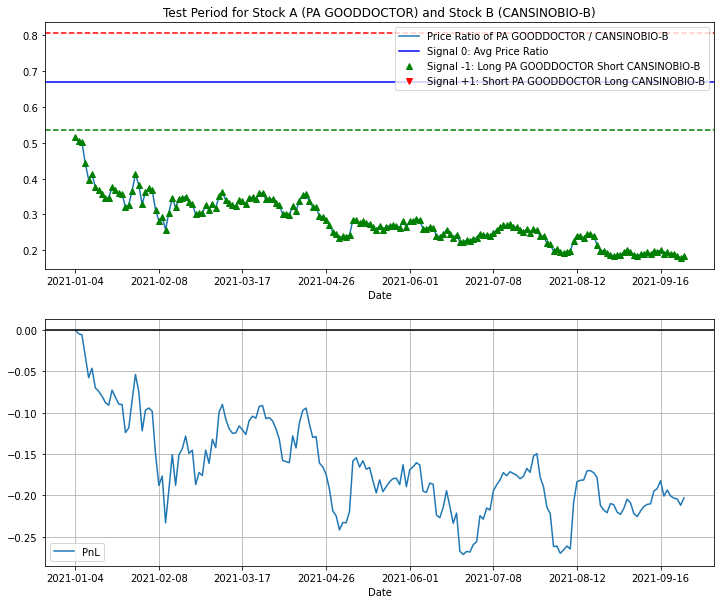

In [20]:
print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", tradingParams['longA_shortB_ratio'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", tradingParams['shortA_longB_ratio'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: ", tradingParams['avgPxRatio'])
print("------------------------------------------------------------------------------------------------------------")
# Backtest a Pair in test period
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B)

# Calcuate the PnL in test period
print("Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)")
print("Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)")
pnl, pnl_df = pairslib.calcPnl(backTest_df)
print("*** PnL:", pnl)
print("==================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].legend(loc ='upper right')

pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')

In [21]:
# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == True)]
print("Total pairs with same sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
threshold=0.2
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# look at one of the pairs backtest results
# Each backtested Pairs is a dataframe with these columns (Date, stockA, stockB, signal, dollarValue)
#pairsPortfolioBackTest[0]

# Calcuate the PnL of the Pairs portfolio
pnlsi, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with same sectors for backtesting: 25
----------------------------------------------------------
FLAT GLASS vs XINYI GLASS ---> $ 5501.934611466724
PHARMARON vs WUXI BIO ---> $ 0
ZHONGSHENG HLDG vs MEIDONG AUTO ---> $ -1017.0433590373777
BANK OF CHINA vs ICBC ---> $ 0
HSBC HOLDINGS vs HANG SENG BANK ---> $ 0
BYD COMPANY vs GREATWALL MOTOR ---> $ 2507.9981548483465
ANTA SPORTS vs LI NING ---> $ -2581.6641001269254
CG SERVICES vs EVERSUNSHINE LS ---> $ 2824.7275257903857
CNOOC vs PETROCHINA ---> $ -1993.0743198788568
CHINA UNICOM vs CHINA TELECOM ---> $ -386.08156751564456
PICC GROUP vs CHINA TAIPING ---> $ 3141.696991266388
SANDS CHINA LTD vs WYNN MACAU ---> $ 1018.3087096525605
CHINA YOUZAN vs MEITUAN-W ---> $ -1284.9698730208402
SINOPEC CORP vs PETROCHINA ---> $ -516.6478190978214
WEIGAO GROUP vs MICROPORT ---> $ -3612.257297728629
HKEX vs CSC ---> $ -1540.1793364134282
MEITUAN-W vs CHINA LIT ---> $ 5716.934363496268
ICBC vs ABC ---> $ 0
KINGSOFT vs KINGDEE INT'L ---> $ -2

,stockA,stocksB,Pnl
0,FLAT GLASS,XINYI GLASS,5501.934611
1,PHARMARON,WUXI BIO,0.000000
2,ZHONGSHENG HLDG,MEIDONG AUTO,-1017.043359
3,BANK OF CHINA,ICBC,0.000000
4,HSBC HOLDINGS,HANG SENG BANK,0.000000
5,BYD COMPANY,GREATWALL MOTOR,2507.998155
6,ANTA SPORTS,LI NING,-2581.664100
7,CG SERVICES,EVERSUNSHINE LS,2824.727526
8,CNOOC,PETROCHINA,-1993.074320
9,CHINA UNICOM,CHINA TELECOM,-386.081568


In [22]:
# Selects the Pairs with different sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == False)]
print("Total pairs with different sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with different sectors for backtesting: 444
----------------------------------------------------------
FLAT GLASS vs XINYI SOLAR ---> $ -2444.593328044908
MEIDONG AUTO vs MEITUAN-W ---> $ 218.41700676567234
MAN WAH HLDGS vs ZIJIN MINING ---> $ 1316.3957632560268
TENCENT vs ZHONGSHENG HLDG ---> $ 616.1725380506823
XINYI GLASS vs XINYI SOLAR ---> $ 4423.204863883027
MEITUAN-W vs ZHONGSHENG HLDG ---> $ 5917.865940348873
XIAOMI-W vs MAN WAH HLDGS ---> $ 858.2170462962349
YIHAI INTL vs CG SERVICES ---> $ -4694.68739824778
TECHTRONIC IND vs MEITUAN-W ---> $ 5134.080666795315
XINYI SOLAR vs GREATWALL MOTOR ---> $ -2951.545196472767
XINYI SOLAR vs WUXI BIO ---> $ 4047.355790757614
WUXI APPTEC vs PHARMARON ---> $ 1347.7111684790289
MENGNIU DAIRY vs ZIJIN MINING ---> $ 62.00384305118678
MAN WAH HLDGS vs MENGNIU DAIRY ---> $ 2973.8915928734177
MAN WAH HLDGS vs WUXI BIO ---> $ -2041.439099282804
XIAOMI-W vs XINYI GLASS ---> $ -557.4298730443152
MEITUAN-W vs TENCENT ---> $ -377.11983740

,stockA,stocksB,Pnl
0,FLAT GLASS,XINYI SOLAR,-2444.593328
1,MEIDONG AUTO,MEITUAN-W,218.417007
2,MAN WAH HLDGS,ZIJIN MINING,1316.395763
3,TENCENT,ZHONGSHENG HLDG,616.172538
4,XINYI GLASS,XINYI SOLAR,4423.204864
...,...,...,...
439,FL2 CSOP HSI,BOC HONG KONG,2076.208919
440,BYD ELECTRONIC,HENGTEN NET,4244.598414
441,CSC,COMEC,0.000000
442,MEIDONG AUTO,FLAT GLASS,1935.440609


In [23]:
#Calculate the total PnL
Total_PnL = pnl+pnlsi
print(Total_PnL)

231444.29608961786
